In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
from scipy import interpolate

In [2]:
w0vec = [-0.7, -1.0, -1.3]
wavec = [-0.2,0.0,0.2]
#w0vec = [-1.0]
#wavec = [0.0]

cosmo = {}
for w0 in w0vec:
    for wa in wavec:
        if w0==-1.0 and wa==0.0:
            M='LCDM'
        else:
            M = '('+str(w0)+','+str(wa)+')'
        cosmo[M] = Class()
        cosmo[M].set({'input_verbose':1,'background_verbose':1,'gauge' : 'Newtonian'})
        if M!='LCDM':
            cosmo[M].set({'Omega_Lambda':0.,'w0_fld':w0,'wa_fld':wa})
        cosmo[M].compute()

In [3]:
import scipy
import scipy.special
import scipy.integrate

def D_hypergeom(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    if bg.has_key('(.)rho_lambda'):
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        
    x = Ol/Om*avec**3
    D = avec*scipy.special.hyp2f1(1./3.,1,11./6.,-x)
    D_today = scipy.special.hyp2f1(1./3.,1,11./6.,-Ol/Om)
    return D/D_today

def f_hypergeom(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    if bg.has_key('(.)rho_lambda'):
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        
    x = Ol/Om*avec**3
    D = avec*scipy.special.hyp2f1(1./3.,1,11./6.,-x)
    f = 1.-6./11.*x*avec/D*scipy.special.hyp2f1(4./3.,2,17./6.,-x)
    return f

def D_integral2(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    if bg.has_key('(.)rho_lambda'):
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
        w0 = -1
        wa = 0.0
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        w0 = csm.pars['w0_fld']
        wa = csm.pars['wa_fld']
    D = np.zeros(avec.shape)
    for idx, a in enumerate(avec):
        Hc = a*np.sqrt(Om/a**3 + Ol*a**(-3*(1+w0+wa))*np.exp(-3.*(1.0-a)*wa) )
        Dintegrand2 = lambda a: (a*np.sqrt(Om/a**3 + Ol*a**(-3*(1+w0+wa))*np.exp(-3.*(1.0-a)*wa) ))**(-3)
        I = scipy.integrate.quad(Dintegrand2, 1e-15,a)
        D[idx] = Hc/a*I[0]
    D = D/scipy.integrate.quad(Dintegrand2,1e-15,1)[0]
    return D

def D_integral(avec,csm):
    bg = csm.get_background()
    Om = csm.Omega0_m()
    Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
    Or = 1-Om-Ol
    def Dintegrand(a):
        Hc = np.sqrt(Om/a+Ol*a*a+Or/a/a)
        #print a,Hc
        return Hc**(-3)
    D = np.zeros(avec.shape)
    for idx, a in enumerate(avec):
        #if a<1e-4:
        #    continue
        Hc = np.sqrt(Om/a+Ol*a*a+Or/a/a)
        I = scipy.integrate.quad(Dintegrand,1e-15,a,args=())
        D[idx] = Hc/a*I[0]
    D = D/scipy.integrate.quad(Dintegrand,1e-15,1,args=())[0]
    return D

def D_linder(avec,csm):
    bg = csm.get_background()
    if bg.has_key('(.)rho_lambda'):
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
        w0 = -1
        wa = 0.0
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        w0 = csm.pars['w0_fld']
        wa = csm.pars['wa_fld']
        
    Om_of_a = (bg['(.)rho_cdm']+bg['(.)rho_b'])/bg['H [1/Mpc]']**2
    gamma = 0.55+0.05*(w0+0.5*wa)
    a_bg = 1./(1.+bg['z'])
    
    integ = (Om_of_a**gamma-1.)/a_bg
    
    integ_interp = interpolate.interp1d(a_bg,integ)
    D = np.zeros(avec.shape)
    amin = min(a_bg)
    amin = 1e-3
    for idx, a in enumerate(avec):
        if a<amin:
            D[idx] = a
        else:
            I = scipy.integrate.quad(integ_interp,amin,a,args=())
            D[idx] = a*np.exp(I[0])
#    D = D/scipy.integrate.quad(Dintegrand,1e-15,1,args=())[0]
    return D

def D_linder2(avec,csm):
    bg = csm.get_background()
    if bg.has_key('(.)rho_lambda'):
        Ol = bg['(.)rho_lambda'][-1]/bg['(.)rho_crit'][-1]
        w0 = -1
        wa = 0.0
        rho_de = bg['(.)rho_lambda']
    else:
        Ol = bg['(.)rho_fld'][-1]/bg['(.)rho_crit'][-1]
        w0 = csm.pars['w0_fld']
        wa = csm.pars['wa_fld']
        rho_de = bg['(.)rho_fld']
        
    rho_M = bg['(.)rho_cdm']+bg['(.)rho_b']
    #Om_of_a = rho_M/bg['H [1/Mpc]']**2
    
    Om_of_a = rho_M/(rho_M+rho_de)
    gamma = 0.55+0.05*(1+w0+0.5*wa)
    #a_bg = 1./(1.+bg['z'])
    a_bg = avec
    integ = (Om_of_a**gamma-1.)/a_bg
    D = np.zeros(avec.shape)
    for idx, a in enumerate(avec):
        if idx<2:
            I=0
        else:
            I = np.trapz(integ[:idx],x=avec[:idx])
        D[idx] = a*np.exp(I)
#    D = D/scipy.integrate.quad(Dintegrand,1e-15,1,args=())[0]
    return D/D[-1]
    
    
def draw_vertical_redshift(csm, theaxis, var='tau',z=99,ls='-.',label='$z=99$'):
    if var=='z':
        xval = z
    elif var=='a':
        xval = 1./(z+1)
    elif var=='tau':
        bg = csm.get_background()
        f = interpolate.interp1d(bg['z'],bg['conf. time [Mpc]'])
        xval = f(z)
    theaxis.axvline(xval,lw=1,ls=ls,color='k',label=label)



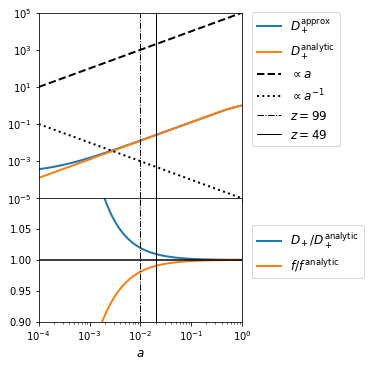

In [4]:
figwidth1 = 4.4 #=0.7*6.3
figwidth2 = 6.3
figwidth15 = 0.5*(figwidth1+figwidth2)
ratio = 8.3/11.7
figheight1 = figwidth1*ratio
figheight2 = figwidth2*ratio
figheight15 = figwidth15*ratio

lw=2
fs=12
labelfs=16

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(1.2*figwidth1,figheight1/(3./5.)),sharex=True,
                              gridspec_kw = {'height_ratios':[3, 2]})

if False:
    aminexp = -13
    amin = 10**aminexp
    ymin = 10**(aminexp/2.)
    ymax = 10**(-aminexp/2.)
elif False:
    aminexp = -7
    amin = 10**aminexp
    ymin = 10**(aminexp)
    ymax = 10**(-aminexp)
else:
    aminexp = -4
    amin = 10**aminexp
    ymin = 10**(aminexp-1)
    ymax = 10**(-aminexp+1)
    

bg = cosmo['LCDM'].get_background()

a = 1./(bg['z']+1)
H = bg['H [1/Mpc]']
D = bg['gr.fac. D']
f = bg['gr.fac. f']

ax1.loglog(a,D,lw=lw,label=r'$D_+^\mathrm{approx}$')
ax1.loglog(a,D_hypergeom(a,cosmo['LCDM']),lw=lw,label=r'$D_+^\mathrm{analytic}$')

ax1.loglog(a,a*ymax,'k--',lw=lw,label=r'$\propto a$')
ax1.loglog(a,1./a*ymin,'k:',lw=lw,label=r'$\propto a^{-1}$')

ax2.semilogx(a,D/D_hypergeom(a,cosmo['LCDM']),lw=lw,label=r'$D_+/D_+^\mathrm{analytic}$')
#ax2.semilogx(a,grow/grow[-1]/D_integral(a,cosmo['CDM']),'--',lw=5)
ax2.semilogx(a,f/f_hypergeom(a,cosmo['LCDM']),lw=lw,label=r'$f/f^{\,\mathrm{analytic}}$')


draw_vertical_redshift(cosmo['LCDM'], ax1, var='a',z=99,label='$z=99$')
draw_vertical_redshift(cosmo['LCDM'], ax1, var='a',z=49,label='$z=49$',ls='-')
draw_vertical_redshift(cosmo['LCDM'], ax2, var='a',z=99,label=None)
draw_vertical_redshift(cosmo['LCDM'], ax2, var='a',z=49,label=None,ls='-')

lgd1 = ax1.legend(fontsize=fs,ncol=1,loc='upper left',
           bbox_to_anchor=(1.02, 1.035))

#lgd2 = ax2.legend([r'$D_+/D_+^\mathrm{analytic}$','$z=99$'],
#           fontsize=fs,ncol=1,loc='upper left',
#           bbox_to_anchor=(1.0, 1.08))
lgd2 = ax2.legend(fontsize=fs,ncol=1,loc='upper left',
           bbox_to_anchor=(1.02, 0.83))

ax1.set_xlim([10**aminexp,1]) 
ax2.set_xlabel(r'$a$',fontsize=fs)
ax1.set_ylim([ymin,ymax])
ax2.set_ylim([0.9,1.099])

ax2.axhline(1,color='k')


fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
fig.savefig('NewtonianGrowthFactor.pdf',bbox_extra_artists=(lgd1,lgd2), bbox_inches='tight')

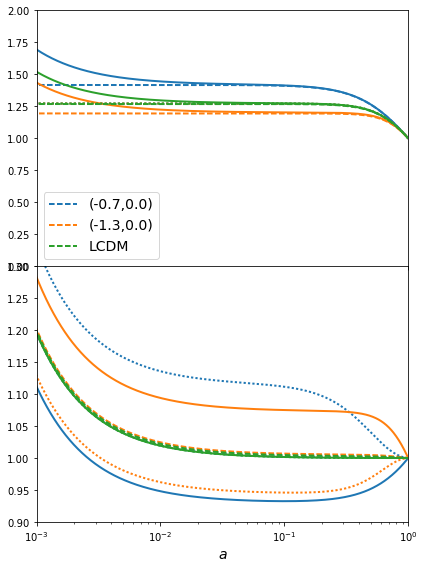

In [14]:
lw=2
fs=14
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,8),sharex=True,)
#                              gridspec_kw = {'height_ratios':[2, 1]})
for M, csm in cosmo.iteritems():
    if M!='LCDM':
        w0, wa = M.strip('()').split(',')
        if float(wa)!=0.0:
            continue
    bg = csm.get_background()
    a = 1./(bg['z']+1)
    H = bg['H [1/Mpc]']
    #grow = bg['grow']
    #grow_prime = bg['grow_prime']
    D = bg['gr.fac. D']
    f = bg['gr.fac. f']
    #grow_interp = interpolate.interp1d(a,grow)
    #p = ax1.semilogx(a,grow/grow[-1]/a,lw=lw,label=M)
    #colour = p[0].get_color()
    
    p=ax1.semilogx(a,D_linder2(a,csm)/a,lw=lw,ls='--',label=M)
    colour = p[0].get_color()
    ax1.semilogx(a,D/a,lw=lw,ls='-',color=colour)
    ax1.semilogx(a,D_hypergeom(a,csm)/a,lw=lw,ls=':',color=colour)
    
    ax2.semilogx(a,D/D_integral2(a,csm),lw=lw,ls='-',color=colour)
    ax2.semilogx(a,D/D_hypergeom(a,csm),lw=lw,ls=':',color=colour)
    ax2.semilogx(a,D/D_linder2(a,csm),lw=lw,ls='--',color=colour)

ax1.set_xlim([1e-3,1]) 
ax2.set_xlabel(r'$a$',fontsize=fs)
ax1.set_ylim([0,2])
ax2.set_ylim([0.9,1.3])

lgd1 = ax1.legend(fontsize=fs,ncol=1,loc='lower left')
#           bbox_to_anchor=(1.0, 1.035))

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)
fig.savefig('Growthrate_w0.pdf')